In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
import itertools   

In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Assignment 5 Dataset.zip" 

In [0]:
data_dir='/content/Assignment 5 Dataset'

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(350),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(350),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])



val_transforms = transforms.Compose([transforms.Resize(350),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [0]:
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=val_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


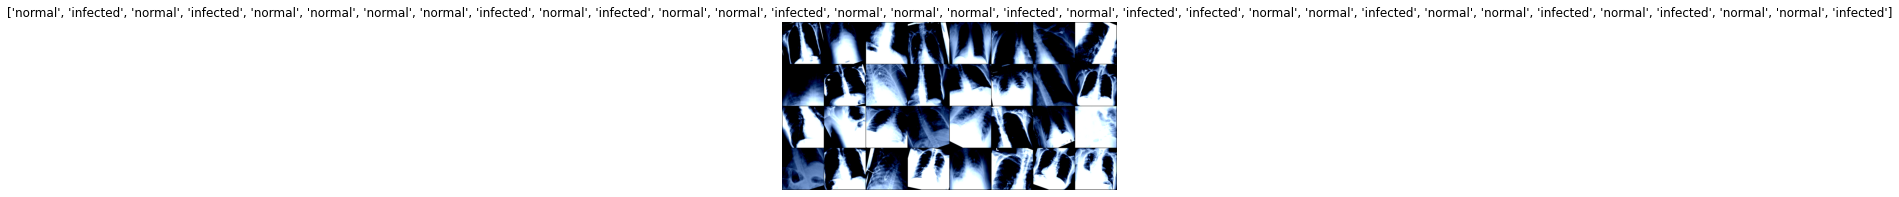

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
resnet=models.resnet34(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
num_features=resnet.fc.in_features
features = list(resnet.fc.children())[:-1] # Remove last layer
print(features)

[]


In [0]:
num_features

512

In [0]:
resnet.layer1.requires_grad_=False
resnet.layer2.requires_grad_=False
resnet.layer3.requires_grad_=False
resnet.layer4.requires_grad_=False
resnet.bn1.requires_grad_=False
resnet.conv1.requires_grad_=False
resnet.relu.requires_grad_=False
resnet.maxpool.requires_grad_=False



In [0]:
features.extend([nn.Linear(num_features, 360)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(360, len(class_names))])

In [0]:
print(features)

[Linear(in_features=512, out_features=360, bias=True), ReLU(inplace=True), Linear(in_features=360, out_features=2, bias=True)]


In [0]:
resnet.fc=nn.Sequential(*features)

In [0]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [0]:
torch.cuda.is_available()

True

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()
k=0

EpochlosslistTrain=[]
EpochlosslistVal=[]

EpochAccListTrain=[]
EpochAccListVal=[]
    
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    i=0
    
    losslistTrain=[]
    losslistVal=[]

    AccListTrain=[]
    AccListVal=[]
    
    for data,valData in itertools.zip_longest(trainloader,valloader):
        correct = 0
        total = 0
        # get the inputs
        inputs, labels = data        
        inputs, labels = inputs.to(device), labels.to(device)

        if(valData is not None):
          val_input,val_labels=valData
          val_input,val_labels = val_input.to(device), val_labels.to(device)
          val_output=resnet(val_input) 
          val_loss = criterion(val_output, val_labels)          
          _, val_predicted = torch.max(val_output.data, 1)
          val_total = val_labels.size(0)
          val_correct = (val_predicted == val_labels).sum().item()
          val_acc=100*val_correct/val_total        
          AccListVal.append(val_acc)
          losslistVal.append(val_loss.data.item())




        optimizer.zero_grad()
        outputs = resnet(inputs)               #----> forward pass
        
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc=100 * correct / total
        AccListTrain.append(acc)
        losslistTrain.append(loss.data.item())






        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
        i+=1
    
    lossVal=sum(losslistVal)/len(losslistVal)
    accVal=sum(AccListVal)/len(AccListVal)

    losstrain=sum(losslistTrain)/len(losslistTrain)
    acctrain=sum(AccListTrain)/len(AccListTrain)

    
    EpochlosslistTrain.append(losstrain)
    EpochlosslistVal.append(lossVal)

    EpochAccListTrain.append(acctrain)
    EpochAccListVal.append(accVal)
      


    torch.save(resnet.state_dict(), '/content/gdrive/My Drive/Models/resnet_ft.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.

Train Epoch: 1 [4192/12000 (35%)]	Loss: 0.198951: : 0it [03:17, ?it/s]

Train Epoch: 1 [4224/12000 (35%)]	Loss: 0.157600: : 0it [03:19, ?it/s]

Train Epoch: 1 [4256/12000 (35%)]	Loss: 0.231178: : 0it [03:20, ?it/s]

Train Epoch: 1 [4288/12000 (36%)]	Loss: 0.534519: : 0it [03:21, ?it/s]

Train Epoch: 1 [4320/12000 (36%)]	Loss: 0.202653: : 0it [03:22, ?it/s]

Train Epoch: 1 [4352/12000 (36%)]	Loss: 0.224534: : 0it [03:24, ?it/s]

Train Epoch: 1 [4384/12000 (37%)]	Loss: 0.228543: : 0it [03:25, ?it/s]

Train Epoch: 1 [4416/12000 (37%)]	Loss: 0.327831: : 0it [03:26, ?it/s]

Train Epoch: 1 [4448/12000 (37%)]	Loss: 0.293635: : 0it [03:27, ?it/s]

Train Epoch: 1 [4480/12000 (37%)]	Loss: 0.152296: : 0it [03:28, ?it/s]

Train Epoch: 1 [4512/12000 (38%)]	Loss: 0.379346: : 0it [03:30, ?it/s]

Train Epoch: 1 [4544/12000 (38%)]	Loss: 0.236280: : 0it [03:31, ?it/s]

Train Epoch: 1 [4576/12000 (38%)]	Loss: 0.160200: : 0it [03:32, ?it/s]

Train Epoch:

Finished Training


In [0]:
EpochlosslistTrain

[0.3562170133590698,
 0.2650579015215238,
 0.2402537463605404,
 0.23460667020082474,
 0.2176210017402967]

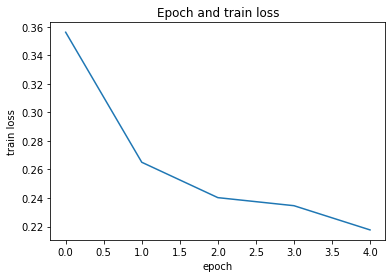

In [0]:
countList=[]
for x in range(Epochs):
  countList.append(x)

plt.plot(countList, EpochlosslistTrain)
# Label the axes
plt.xlabel('epoch')
plt.ylabel('train loss')
#label the figure
plt.title('Epoch and train loss')
plt.show()



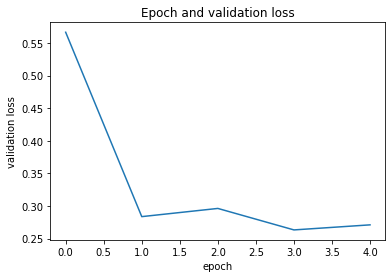

In [0]:
plt.plot(countList, EpochlosslistVal)
# Label the axes
plt.xlabel('epoch')
plt.ylabel('validation loss')
#label the figure
plt.title('Epoch and validation loss')
plt.show()


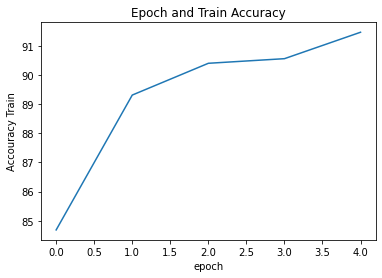

In [0]:
plt.plot(countList, EpochAccListTrain)
# Label the axes
plt.xlabel('epoch')
plt.ylabel('Accouracy Train')
#label the figure
plt.title('Epoch and Train Accuracy')
plt.show()


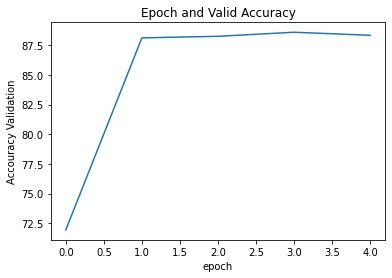

In [0]:
plt.plot(countList, EpochAccListVal)
# Label the axes
plt.xlabel('epoch')
plt.ylabel('Accouracy Validation')
#label the figure
plt.title('Epoch and Valid Accuracy')
plt.show()

In [0]:
correct = 0
total = 0
confusion_matrix = torch.zeros(2, 2)
confusion_matrixValid = torch.zeros(2, 2)
confusion_matrixTrain = torch.zeros(2, 2)
lowestLoss=2
highestlossList=[]
lowestLossList=[]

with torch.no_grad():
    for data,traindata,valdata in zip(testloader,trainloader,valloader):
        highestIndex=-1
        lowestIndex=-1


        #test Part
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):          
          confusion_matrix[t.long(), p.long()] += 1

        #train Part
        imagesTrain, labelsTrain = traindata
        imagesTrain, labelsTrain = imagesTrain.to(device), labelsTrain.to(device)
        outputsTrain = resnet(imagesTrain)
        _, predictedTrain = torch.max(outputsTrain.data, 1)
        for t, p in zip(labelsTrain.view(-1), predictedTrain.view(-1)):          
          confusion_matrixTrain[t.long(), p.long()] += 1

          #valid Part
        imagesval, labelsval = valdata
        imagesval, labelsval = imagesval.to(device), labelsval.to(device)
        outputsval = resnet(imagesval)
        _, predictedval = torch.max(outputsval.data, 1)
        for t, p in zip(labelsval.view(-1), predictedval.view(-1)):          
          confusion_matrixValid[t.long(), p.long()] += 1


        k=0
        
        # for o,l in zip(outputs,labels):          
        #   loss = criterion(o, l)
        #   if(loss<lowestLoss):
        #     lowestLoss=loss
        #     lowestLossList.clear();
        #     lowestLossList.append(data[k])
        #   elif(loss>highestloss):
        #     highestloss=loss
        #     highestlossList.clear()
        #     highestlossList.append(data[k])
        #   k+=1




        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [0]:
confusion_matrix


tensor([[573.,  42.],
        [ 24., 861.]])

In [0]:
confusion_matrixValid

tensor([[552.,  63.],
        [ 81., 804.]])

In [0]:
confusion_matrixTrain

tensor([[568.,  73.],
        [ 69., 794.]])

In [0]:
truePositive=confusion_matrix[0,0].item()
FP=confusion_matrix[0,1].item()
FN=confusion_matrix[1,0].item()
TN=confusion_matrix[1,1].item()


precission=truePositive/(truePositive+FP)
recall=truePositive/(truePositive+FN)

F1=2 * ((precission*recall)/(precission+recall))
print("F1 score")
print(F1)

F1 score
0.9455445544554456
